In [2]:
%matplotlib inline

import os, sys
import numpy as np
import pylab as plt
from scipy.interpolate import griddata
from PIL import Image


In [15]:
def load_tiff_image(dataFile):
    dataImg = Image.open(dataFile)
    X = [];
    for ii in xrange(sys.maxint):
        Xi = np.array(dataImg, dtype=np.float32)
        if Xi.ndim == 2:
            Xi = Xi[np.newaxis, ...] # add slice dimension
        X.append(Xi)
        try:
            dataImg.seek(dataImg.tell()+1)
        except EOFError:
            break # this just means hit end of file (not really an error)

    X = np.concatenate(X, axis=0)  # list of 2d -> tensor
    return X

# load a test image
f = load_tiff_image('/Users/pekalmj1/Data/ISBI-2012/train-volume.tif')
X = f[0, ...]
n = X.shape[0]

In [31]:
glue = lambda X, Y: np.vstack([X.flatten(), Y.flatten()]).transpose()

# the domain Omega is [0:n]^2
omega_x, omega_y = np.meshgrid(np.arange(n), np.arange(n))

# create random displacement vectors at 9 locations in the domain.
d_pts = np.array([0, 128, 256, 382, 512], dtype=np.int32)
d_xx, d_yy = np.meshgrid(d_pts, d_pts)

if 0:
    sigma = 20
    dx = sigma * np.random.randn(d_xx.size)
    dy = sigma * np.random.randn(d_xx.size)
else:
    # deterministic displacement (for testing)
    dx = 10 * np.ones(d_xx.size)
    dy = 10 * np.ones(d_yy.size)
    
# use interpolation to generate a smooth displacement field.
omega_dx = griddata(glue(d_xx, d_yy), dx.flatten(), glue(omega_x, omega_y))
omega_dy = griddata(glue(d_xx, d_yy), dy.flatten(), glue(omega_x, omega_y))

omega_dx = np.reshape(omega_dx, (n,n))
omega_dy = np.reshape(omega_dy, (n,n))

# generate a perturbed mesh
omega_xnew = omega_x + omega_dx
omega_ynew = omega_y - omega_dy

# use interpolation to estimate pixel intensities back on the original lattice
X_new = griddata(glue(omega_xnew, omega_ynew), X.flatten(), glue(omega_x, omega_y))
X_new = np.reshape(X_new, (n,n))

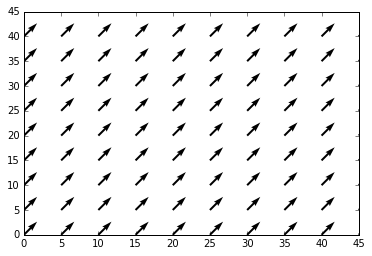

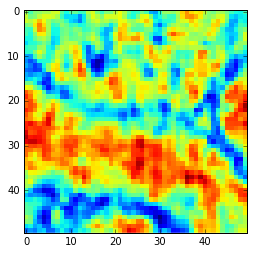

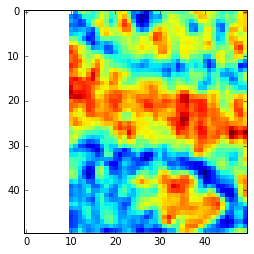

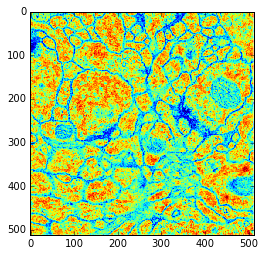

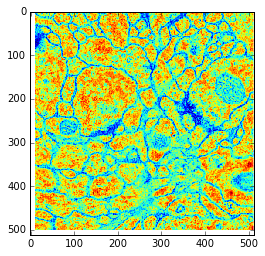

In [32]:
# visualize
subset = lambda M,d:  M[0:50:d, 0:50:d]

plt.quiver(subset(omega_x,5), subset(omega_y,5), subset(omega_dx,5), subset(omega_dy,5))
plt.figure()
plt.imshow(subset(X,1), interpolation='none')
plt.figure()
plt.imshow(subset(X_new,1), interpolation='none')

plt.figure()
plt.imshow(X, interpolation='none')
plt.figure()
plt.imshow(X_new, interpolation='none')